In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from tabulate import tabulate

In [3]:
#Primero vamos a cargar la base de datos pero a partir de la concatenación de dataframes hechos con base en las hojas '2016', '2017', ..., '2023' 
#del libro 'Homicidios_2016-2023.xlsx' de excel.
#Esto lo haremos para comprobar que la concatenación coincide con la hoja '2016-2023' del mismo libro, donde ya tengo todos los datos desde 2016 hasta 2017.

sheets = ["2016", "2017", "2018", "2019", "2020", "2021", "2022_1", "2022_2", "2023"]

dataframes = []

for sheet in sheets:
    df = pd.read_excel("bdentrada/Homicidios_2016-2023.xlsx", sheet_name=sheet)

    df.columns = df.columns.str.strip() #limpiar los nombres de las columnas. Evitar espacios no deseados

    #Este bloque maneja el tipo de datos de las columnas de cada dataframe.
    df['FECHA HECHO']=pd.to_datetime(df['FECHA HECHO']).dt.date
    df['CANTIDAD']=pd.to_numeric(df['CANTIDAD']).astype('Int64')
    df['CODIGO DANE']=pd.to_numeric(df['CODIGO DANE']).astype('Int64')
    df['AÑO']=pd.to_numeric(df['AÑO']).astype('Int64')


    dataframes.append(df)

df_unido = pd.concat(dataframes, ignore_index=True) #unificar los datos en un solo DataFrame

# guardamos el DataFrame en formato .xlsx para compararlo con la hoja 2016-2023 del libro
df_unido.to_excel("bdunificada/Homicidios_2016-2023_unificado.xlsx", index=False)

In [4]:
#Hacemos una visualización rápida de los primeros datos de la tabla
print(df_unido.head())

                    ARMA MEDIO DEPARTAMENTO       MUNICIPIO FECHA HECHO  \
0  ARMA BLANCA / CORTOPUNZANTE     AMAZONAS    LETICIA (CT)  2016-01-01   
1  ARMA BLANCA / CORTOPUNZANTE    ANTIOQUIA   MEDELLÍN (CT)  2016-01-01   
2  ARMA BLANCA / CORTOPUNZANTE    ANTIOQUIA     SABANALARGA  2016-01-01   
3  ARMA BLANCA / CORTOPUNZANTE    ANTIOQUIA         YOLOMBÓ  2016-01-01   
4  ARMA BLANCA / CORTOPUNZANTE      BOLÍVAR  CARTAGENA (CT)  2016-01-01   

      GENERO AGRUPA EDAD PERSONA  CODIGO DANE  CANTIDAD   AÑO  
0  MASCULINO             ADULTOS     91001000         1  2016  
1  MASCULINO             ADULTOS      5001000         1  2016  
2  MASCULINO             ADULTOS      5628000         1  2016  
3  MASCULINO             ADULTOS      5890000         1  2016  
4  MASCULINO             ADULTOS     13001000         1  2016  


In [5]:
#Hacemos una visualización rápida de los últimos datos de la tabla
print(df_unido.tail())

         ARMA MEDIO DEPARTAMENTO  MUNICIPIO FECHA HECHO     GENERO  \
95520  CONTUNDENTES        VALLE  SAN PEDRO  2023-06-10   FEMENINO   
95521  CONTUNDENTES        VALLE    SEVILLA  2023-03-15   FEMENINO   
95522  CONTUNDENTES        VALLE   TRUJILLO  2023-02-11  MASCULINO   
95523  CONTUNDENTES        VALLE      YUMBO  2023-05-12  MASCULINO   
95524  CONTUNDENTES        VALLE     ZARZAL  2023-11-11   FEMENINO   

      AGRUPA EDAD PERSONA  CODIGO DANE  CANTIDAD   AÑO  
95520             ADULTOS     76670000         1  2023  
95521             ADULTOS     76736000         1  2023  
95522             ADULTOS     76828000         1  2023  
95523             ADULTOS     76892000         1  2023  
95524             ADULTOS     76895000         1  2023  


In [6]:
#obtenemos información general de la tabla
print(df_unido.info())

<class 'pandas.DataFrame'>
RangeIndex: 95525 entries, 0 to 95524
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ARMA MEDIO           95525 non-null  str   
 1   DEPARTAMENTO         95525 non-null  str   
 2   MUNICIPIO            95525 non-null  str   
 3   FECHA HECHO          95525 non-null  object
 4   GENERO               95525 non-null  str   
 5   AGRUPA EDAD PERSONA  95525 non-null  str   
 6   CODIGO DANE          95525 non-null  Int64 
 7   CANTIDAD             95525 non-null  Int64 
 8   AÑO                  95525 non-null  Int64 
dtypes: Int64(3), object(1), str(5)
memory usage: 6.8+ MB
None


In [7]:
#verificamos que no haya valores nulos en la base de datos
print(df_unido.isna().sum())

ARMA MEDIO             0
DEPARTAMENTO           0
MUNICIPIO              0
FECHA HECHO            0
GENERO                 0
AGRUPA EDAD PERSONA    0
CODIGO DANE            0
CANTIDAD               0
AÑO                    0
dtype: int64


In [8]:
#Este ejemplo de código serviría para eliminar las filas que tuviesen elementos nulos
#df_unido_sin_NaN=df_unido.dropna()
#df_unido_sin_NaN.isna().sum()

In [9]:
#Ahora creamos el dataframe con la hoja '2016-2023', que ya tiene todos los datos. Este será la base para filtrar en los municipios de Antioquia.

df_homicidios=pd.read_excel("bdentrada/Homicidios_2016-2023.xlsx", sheet_name='2016-2023')

df_homicidios.columns = df_homicidios.columns.str.strip() #limpiar los nombres de las columnas. Evitar espacios no deseados

#Este bloque maneja el tipo de datos de las columnas de cada dataframe.
df_homicidios['FECHA HECHO']=pd.to_datetime(df_homicidios['FECHA HECHO']).dt.date
df_homicidios['CANTIDAD']=pd.to_numeric(df_homicidios['CANTIDAD']).astype('Int64')
df_homicidios['CODIGO DANE']=pd.to_numeric(df_homicidios['CODIGO DANE']).astype('Int64')
df_homicidios['AÑO']=pd.to_numeric(df_homicidios['AÑO']).astype('Int64')

In [10]:
#Hacemos una visualización rápida de los primeros datos de la tabla
print(df_homicidios.head())

                    ARMA MEDIO DEPARTAMENTO       MUNICIPIO FECHA HECHO  \
0  ARMA BLANCA / CORTOPUNZANTE     AMAZONAS    LETICIA (CT)  2016-01-01   
1  ARMA BLANCA / CORTOPUNZANTE    ANTIOQUIA   MEDELLÍN (CT)  2016-01-01   
2  ARMA BLANCA / CORTOPUNZANTE    ANTIOQUIA     SABANALARGA  2016-01-01   
3  ARMA BLANCA / CORTOPUNZANTE    ANTIOQUIA         YOLOMBÓ  2016-01-01   
4  ARMA BLANCA / CORTOPUNZANTE      BOLÍVAR  CARTAGENA (CT)  2016-01-01   

      GENERO AGRUPA EDAD PERSONA  CODIGO DANE  CANTIDAD   AÑO  
0  MASCULINO             ADULTOS     91001000         1  2016  
1  MASCULINO             ADULTOS      5001000         1  2016  
2  MASCULINO             ADULTOS      5628000         1  2016  
3  MASCULINO             ADULTOS      5890000         1  2016  
4  MASCULINO             ADULTOS     13001000         1  2016  


In [11]:
#Hacemos una visualización rápida de los últimos datos de la tabla
print(df_homicidios.tail())

         ARMA MEDIO DEPARTAMENTO  MUNICIPIO FECHA HECHO     GENERO  \
95520  CONTUNDENTES        VALLE  SAN PEDRO  2023-06-10   FEMENINO   
95521  CONTUNDENTES        VALLE    SEVILLA  2023-03-15   FEMENINO   
95522  CONTUNDENTES        VALLE   TRUJILLO  2023-02-11  MASCULINO   
95523  CONTUNDENTES        VALLE      YUMBO  2023-05-12  MASCULINO   
95524  CONTUNDENTES        VALLE     ZARZAL  2023-11-11   FEMENINO   

      AGRUPA EDAD PERSONA  CODIGO DANE  CANTIDAD   AÑO  
95520             ADULTOS     76670000         1  2023  
95521             ADULTOS     76736000         1  2023  
95522             ADULTOS     76828000         1  2023  
95523             ADULTOS     76892000         1  2023  
95524             ADULTOS     76895000         1  2023  


In [12]:
#filtrammos solo los homicidios en el departamento de Antioquia
df_Antioquia=df_homicidios[df_homicidios['DEPARTAMENTO'] == 'ANTIOQUIA'] #Esta es la tabla con la que trabajaremos en lo que resta

#Eliminamos las columnas que ya no nos serán útiles.
df_Antioquia=df_Antioquia.drop(columns=['CODIGO DANE', 'DEPARTAMENTO'])

#Cambiamos el valor de MEDELLÍN (CT) a MEDELLÍN. Para que coincida con el shapefile que leeremos después
df_Antioquia['MUNICIPIO']=df_Antioquia['MUNICIPIO'].replace('MEDELLÍN (CT)','MEDELLÍN')

#y damos una vista general a la tabla. Obtenemos información y visualzamos algunos de sus elementos
print(df_Antioquia.info())
print("-----------------------------------------")
print(df_Antioquia.describe())
print("-----------------------------------------")
print(df_Antioquia.head())

<class 'pandas.DataFrame'>
Index: 16105 entries, 1 to 95045
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ARMA MEDIO           16105 non-null  str   
 1   MUNICIPIO            16105 non-null  str   
 2   FECHA HECHO          16105 non-null  object
 3   GENERO               16105 non-null  str   
 4   AGRUPA EDAD PERSONA  16105 non-null  str   
 5   CANTIDAD             16105 non-null  Int64 
 6   AÑO                  16105 non-null  Int64 
dtypes: Int64(2), object(1), str(4)
memory usage: 1.0+ MB
None
-----------------------------------------
       CANTIDAD          AÑO
count   16105.0      16105.0
mean   1.101149  2019.633654
std    0.392129     2.212036
min         1.0       2016.0
25%         1.0       2018.0
50%         1.0       2020.0
75%         1.0       2022.0
max        10.0       2023.0
-----------------------------------------
                     ARMA MEDIO    MUNICIPIO FECHA HECHO   

In [13]:
#después del filtro de departamento, agrupamos por municipio y contamos la cantidad de homicidios en cada uno de ellos
df_cant_municipio=df_Antioquia.groupby('MUNICIPIO')['CANTIDAD'].sum().reset_index().sort_values(by='CANTIDAD', ascending=False)#ordenamos los municipios de forma descendente por cantidad de homicidios 

#tabulamos
print(tabulate(df_cant_municipio,headers='keys',tablefmt='grid',showindex=False))

+------------------------+------------+
| MUNICIPIO              |   CANTIDAD |
+========================+============+
| MEDELLÍN               |       4057 |
+------------------------+------------+
| BELLO                  |        711 |
+------------------------+------------+
| TURBO                  |        675 |
+------------------------+------------+
| CAUCASIA               |        668 |
+------------------------+------------+
| SEGOVIA                |        453 |
+------------------------+------------+
| TARAZÁ                 |        428 |
+------------------------+------------+
| APARTADÓ               |        418 |
+------------------------+------------+
| REMEDIOS               |        357 |
+------------------------+------------+
| CÁCERES                |        349 |
+------------------------+------------+
| EL BAGRE               |        312 |
+------------------------+------------+
| PUERTO BERRÍO          |        311 |
+------------------------+------------+


In [14]:
# Cargamos el shapefile del departamento de todos los municipios de Colombia ('MGN_ADM_MPIO_GRAFICO.shp')
#DANE-2023
gdf_antioquia = gpd.read_file('geoestadistico/MGN_ADM_MPIO_GRAFICO.shp')

# Ver las primeras filas del GeoDataFrame y las columnas
print(gdf_antioquia.head())  # Muestra las primeras filas
print(gdf_antioquia.columns)  # Muestra todas las columnas disponibles

  dpto_ccdgo mpio_ccdgo mpio_cdpmp dpto_cnmbr  mpio_cnmbr  \
0         05        001      05001  ANTIOQUIA    MEDELLÍN   
1         05        002      05002  ANTIOQUIA   ABEJORRAL   
2         05        004      05004  ANTIOQUIA    ABRIAQUÍ   
3         05        021      05021  ANTIOQUIA  ALEJANDRÍA   
4         05        030      05030  ANTIOQUIA       AMAGÁ   

                          mpio_crslc  mpio_tipo  mpio_narea  mpio_nano  \
0                               1965  MUNICIPIO  374.834005       2023   
1                               1814  MUNICIPIO  507.141095       2023   
2                               1912  MUNICIPIO  296.894050       2023   
3  Decreto departamental 304 de 1907  MUNICIPIO  128.932153       2023   
4                               1912  MUNICIPIO   84.132477       2023   

   shape_Leng  shape_Area                                           geometry  
0    1.035380    0.030608  POLYGON ((-75.66974 6.3736, -75.66965 6.3736, ...  
1    1.158504    0.041384  POL

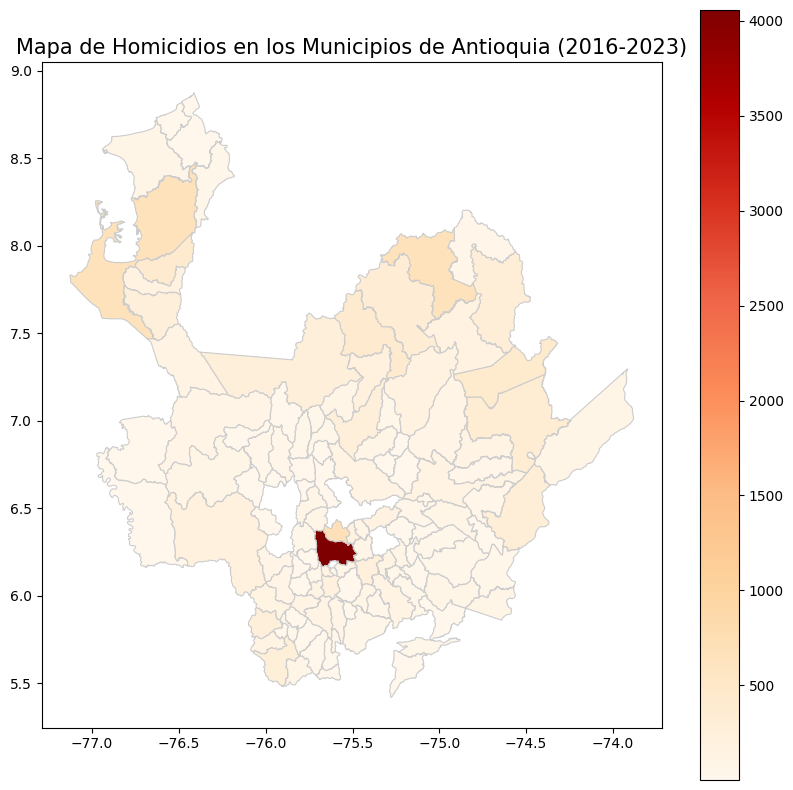

In [15]:
#lo leemos otra vez por temas de manejo de variables en las celdas del notebook de jupyter
gdf_antioquia = gpd.read_file('geoestadistico/MGN_ADM_MPIO_GRAFICO.shp')

#filtramos en el shapefile solo el departamento de Antioquia
gdf_antioquia = gdf_antioquia[gdf_antioquia['dpto_ccdgo']== '05']

# Creamos un DataFrame con la cantidad total de homicidios por municipio
df_homicidios_municipios = df_Antioquia.groupby('MUNICIPIO')['CANTIDAD'].sum().reset_index()

# Unimos los datos geográficos del shapefile con los datos de homicidios
gdf_antioquia = gdf_antioquia.merge(df_homicidios_municipios, how='left', left_on='mpio_cnmbr', right_on='MUNICIPIO')

# Creamos el mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_antioquia.plot(column='CANTIDAD', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Mapa de Homicidios en los Municipios de Antioquia (2016-2023)', fontsize=15)
plt.grid(False)
plt.show()

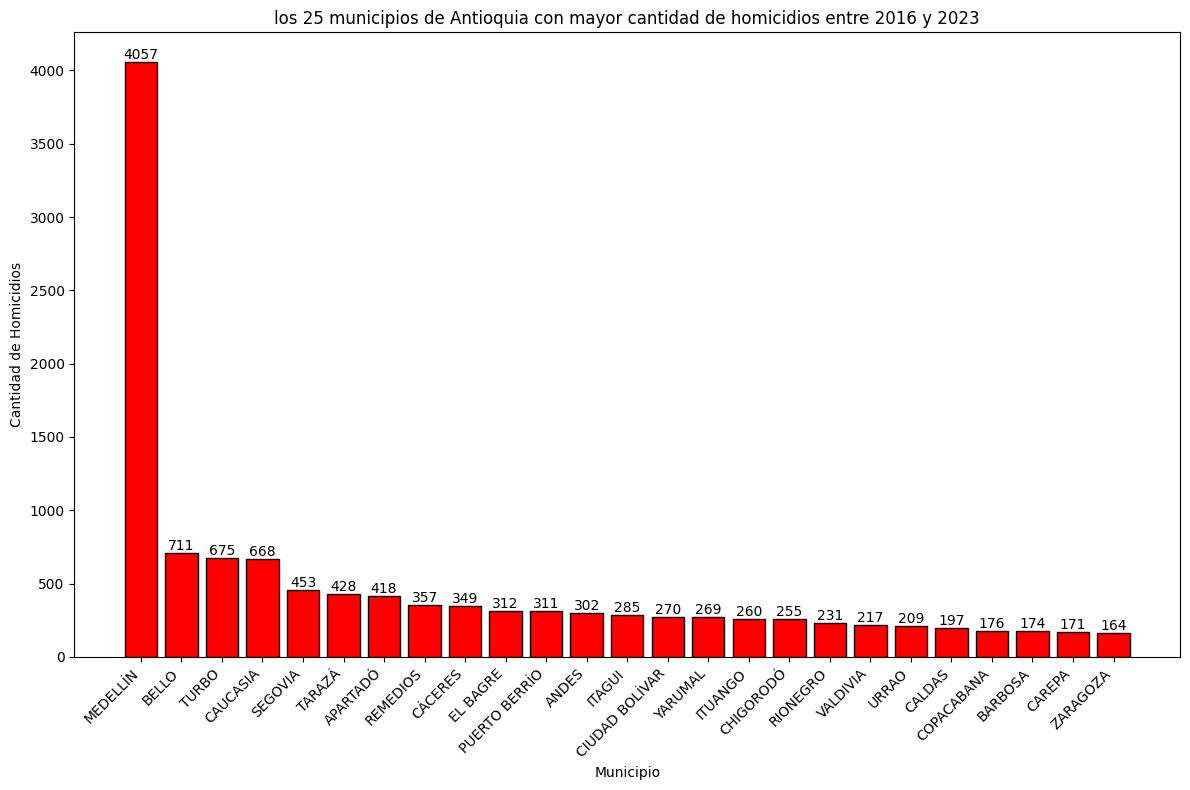

In [16]:
#Hacemos un diagrama de barras con los primeros 25 municipios con mayor cantidad de homicidios. El diagrama con todos los municipios es muy grande,
#y no se puede visualizar correctamente.
#Esto lo hacemos como comparación.

top_n=25
df_top_n=df_cant_municipio.nlargest(top_n,'CANTIDAD')


fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(df_top_n['MUNICIPIO'], df_top_n['CANTIDAD'], color='red', edgecolor='black')

# Agregamos las cantidades encima de las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1),
            ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Municipio')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de Homicidios')
plt.title(f'los {top_n} municipios de Antioquia con mayor cantidad de homicidios entre 2016 y 2023')
plt.tight_layout()
plt.grid(False)
plt.show()

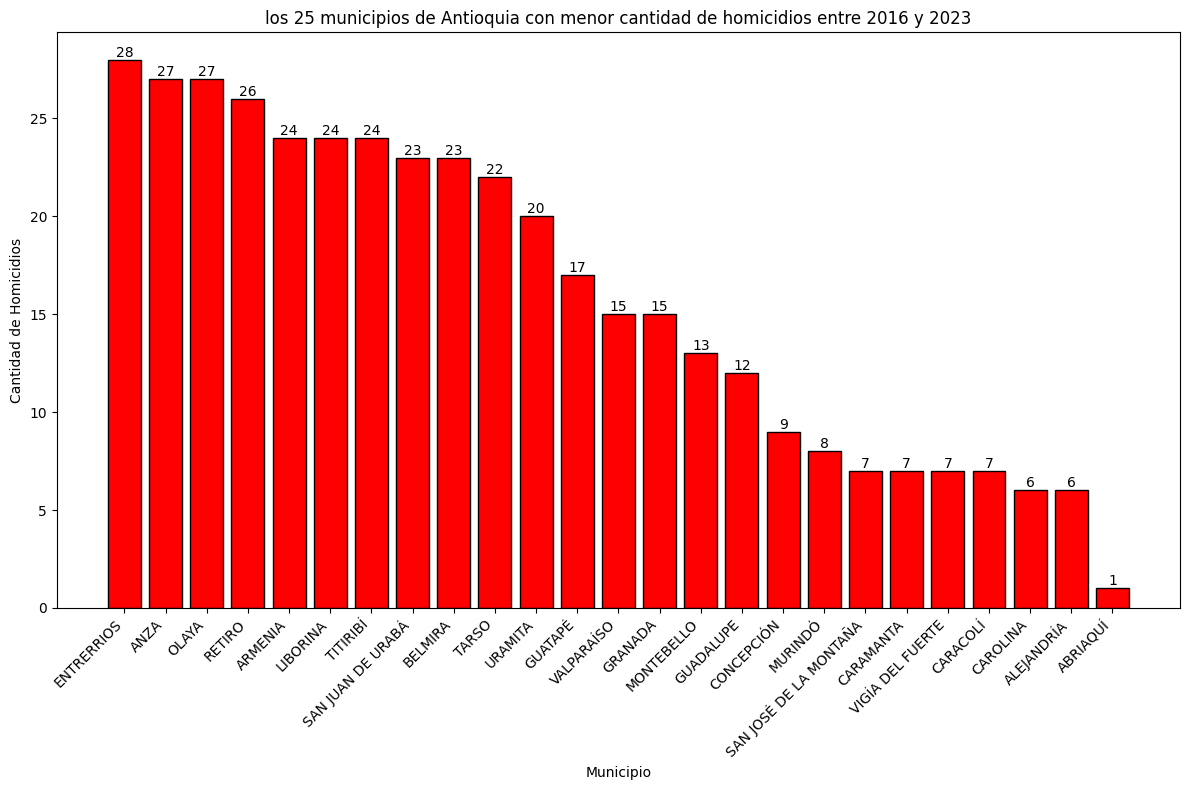

In [17]:
#Hacemos un diagrama de barras con los últimos 25 municipios con mayor cantidad de homicidios. El diagrama con todos los municipios es muy grande,
#y no se puede visualizar correctamente.
#Esto lo hacemos como comparación.
sub_n=25
df_sub_n=df_cant_municipio.nsmallest(sub_n,'CANTIDAD')


fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(df_sub_n.sort_values(by='CANTIDAD', ascending=False)['MUNICIPIO'], df_sub_n.sort_values(by='CANTIDAD', ascending=False)['CANTIDAD'], color='red', edgecolor='black')

# Agregamos las cantidades encima de las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1),
            ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Municipio')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de Homicidios')
plt.title(f'los {top_n} municipios de Antioquia con menor cantidad de homicidios entre 2016 y 2023')
plt.tight_layout()
plt.grid(False)
plt.show()

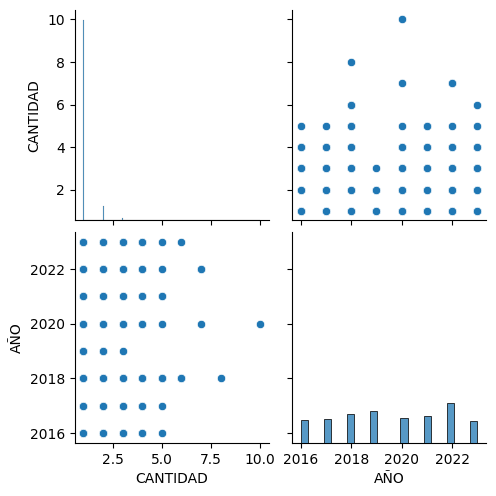

In [18]:
#Graficamos con seaborn las posibles relaciones que pueden haber en el dataframe que ya está limitado al departameno de Antioquia

sns.pairplot(df_Antioquia)

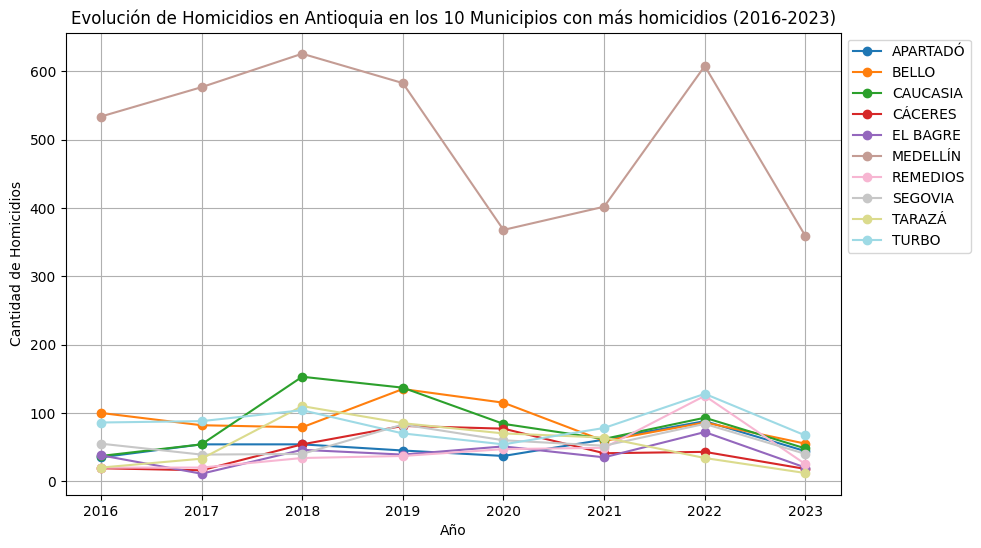

In [19]:
#Agrupamos por MUNICIPIO y sumar la cantidad total de homicidios
df_municipios_htotales = df_Antioquia.groupby('MUNICIPIO')['CANTIDAD'].sum().reset_index()

#Ordenamos los municipios por cantidad de homicidios y seleccionar los primeros n (por ejemplo, n = 5)
top_n = 10
top_municipios = df_municipios_htotales.sort_values(by='CANTIDAD', ascending=False).head(top_n)['MUNICIPIO']

#Filtramos el DataFrame original para incluir solo los municipios seleccionados
df_top_municipios = df_Antioquia[df_Antioquia['MUNICIPIO'].isin(top_municipios)]

#Agrupamos nuevamentem pero por MUNICIPIO y AÑO, y graficar la evolución temporal
df_temporal_top = df_top_municipios.groupby(['MUNICIPIO', 'AÑO'])['CANTIDAD'].sum().unstack()


df_temporal_top.T.plot(figsize=(10, 6), cmap='tab20', marker='o')
plt.title(f'Evolución de Homicidios en Antioquia en los {top_n} Municipios con más homicidios (2016-2023)')
plt.xlabel('Año')
plt.ylabel('Cantidad de Homicidios')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

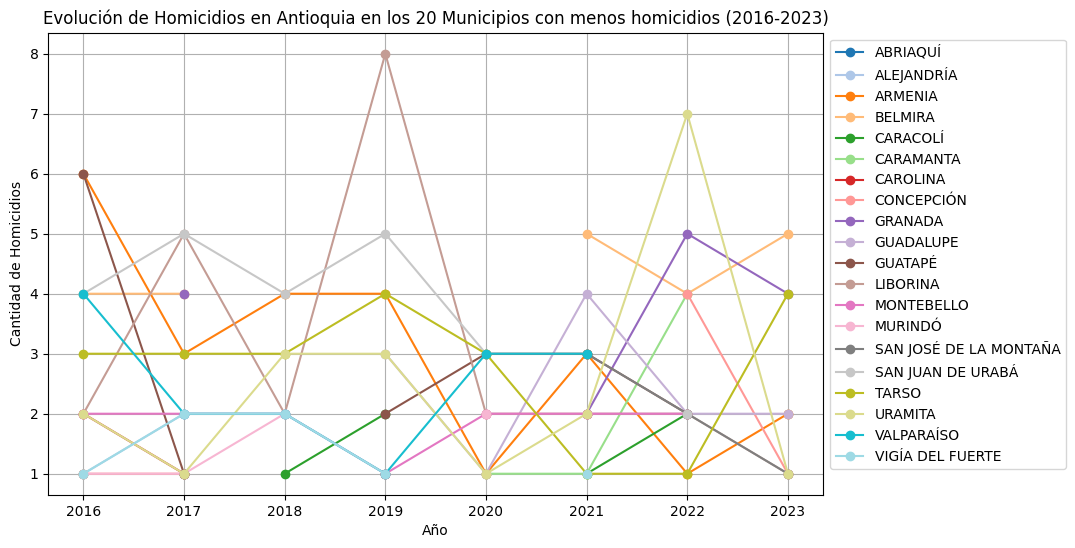

In [20]:
#Ordenamos los municipios por cantidad de homicidios y seleccionar los primeros n (por ejemplo, n = 5)
sub_n = 20
sub_municipios = df_municipios_htotales.sort_values(by='CANTIDAD', ascending=False).tail(sub_n)['MUNICIPIO']

#Filtramos el DataFrame original para incluir solo los municipios seleccionados
df_sub_municipios = df_Antioquia[df_Antioquia['MUNICIPIO'].isin(sub_municipios)]

#Agrupamos nuevamentem pero por MUNICIPIO y AÑO, y graficar la evolución temporal
df_temporal_sub = df_sub_municipios.groupby(['MUNICIPIO', 'AÑO'])['CANTIDAD'].sum().unstack()


df_temporal_sub.T.plot(figsize=(10, 6), cmap='tab20', marker='o')
plt.title(f'Evolución de Homicidios en Antioquia en los {sub_n} Municipios con menos homicidios (2016-2023)')
plt.xlabel('Año')
plt.ylabel('Cantidad de Homicidios')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [21]:
df_ttemp=df_temporal_top.fillna(0)
print(tabulate(df_ttemp.head(), headers='keys', tablefmt='rounded_grid', showindex=True, ))
print("---------------------------------------------------------------------")
print(df_ttemp.info())

╭─────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ MUNICIPIO   │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │   2023 │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ APARTADÓ    │     35 │     54 │     54 │     45 │     37 │     61 │     88 │     44 │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ BELLO       │    100 │     82 │     79 │    135 │    115 │     59 │     86 │     55 │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ CAUCASIA    │     37 │     54 │    153 │    137 │     84 │     62 │     93 │     48 │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ CÁCERES     │     19 │     16 │     54 │     81 │     77 │     41 │     43 │     18 │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ EL BAGRE    │     38 │     11 

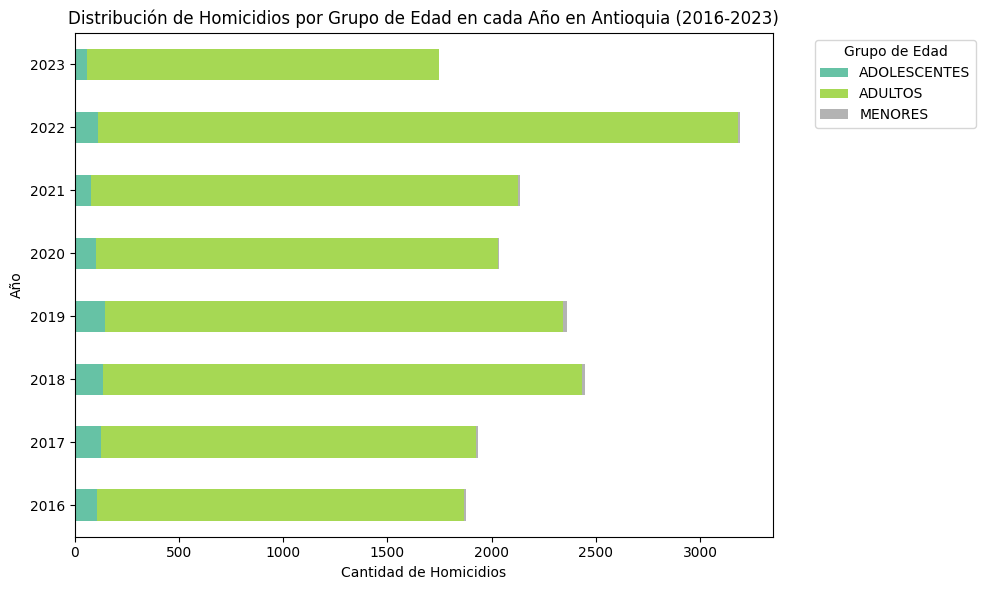

In [22]:
#agrupamos por AÑO y AGRUPA EDAD PERSONA, para hacer un gráfico de barras apiladas de la cantidad de homicidios por año y grupo de persona por edad
df_edad = df_Antioquia.groupby(['AÑO', 'AGRUPA EDAD PERSONA'])['CANTIDAD'].sum().unstack()

# Creamos el gráfico de barras apiladas
ax = df_edad.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title(f'Distribución de Homicidios por Grupo de Edad en cada Año en Antioquia (2016-2023)')
plt.xlabel('Cantidad de Homicidios')
plt.ylabel('Año')
plt.legend(title='Grupo de Edad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadimos los valores sobre las barras
#for c in ax.containers:
    #ax.bar_label(c, label_type='center', fmt='%.0f')  # Mostrar valores enteros

plt.tight_layout()
plt.grid(False)
plt.show()

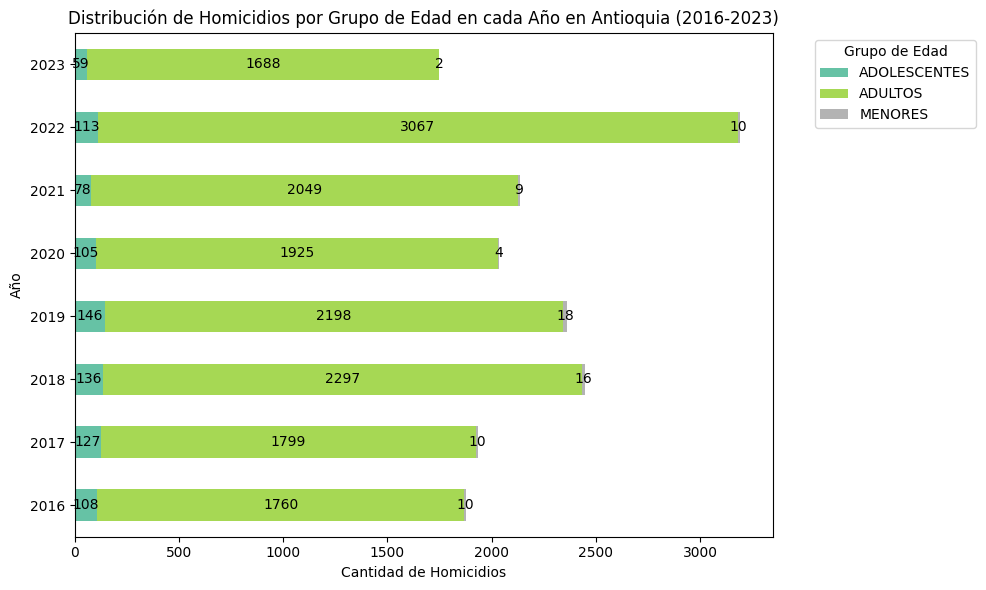

In [23]:
# Creamos el gráfico de barras apiladas
ax = df_edad.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title(f'Distribución de Homicidios por Grupo de Edad en cada Año en Antioquia (2016-2023)')
plt.xlabel('Cantidad de Homicidios')
plt.ylabel('Año')
plt.legend(title='Grupo de Edad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadimos los valores sobre las barras
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%.0f')  # Mostrar valores enteros

plt.tight_layout()
plt.grid(False)
plt.show()

In [24]:
df_edad_total=df_edad
df_edad_total['TOTAL']=df_edad_total.sum(axis=1)
print(tabulate(df_edad_total,headers='keys',tablefmt='simple_grid',showindex=True))

┌───────┬────────────────┬───────────┬───────────┬─────────┐
│   AÑO │   ADOLESCENTES │   ADULTOS │   MENORES │   TOTAL │
├───────┼────────────────┼───────────┼───────────┼─────────┤
│  2016 │            108 │      1760 │        10 │    1878 │
├───────┼────────────────┼───────────┼───────────┼─────────┤
│  2017 │            127 │      1799 │        10 │    1936 │
├───────┼────────────────┼───────────┼───────────┼─────────┤
│  2018 │            136 │      2297 │        16 │    2449 │
├───────┼────────────────┼───────────┼───────────┼─────────┤
│  2019 │            146 │      2198 │        18 │    2362 │
├───────┼────────────────┼───────────┼───────────┼─────────┤
│  2020 │            105 │      1925 │         4 │    2034 │
├───────┼────────────────┼───────────┼───────────┼─────────┤
│  2021 │             78 │      2049 │         9 │    2136 │
├───────┼────────────────┼───────────┼───────────┼─────────┤
│  2022 │            113 │      3067 │        10 │    3190 │
├───────┼───────────────

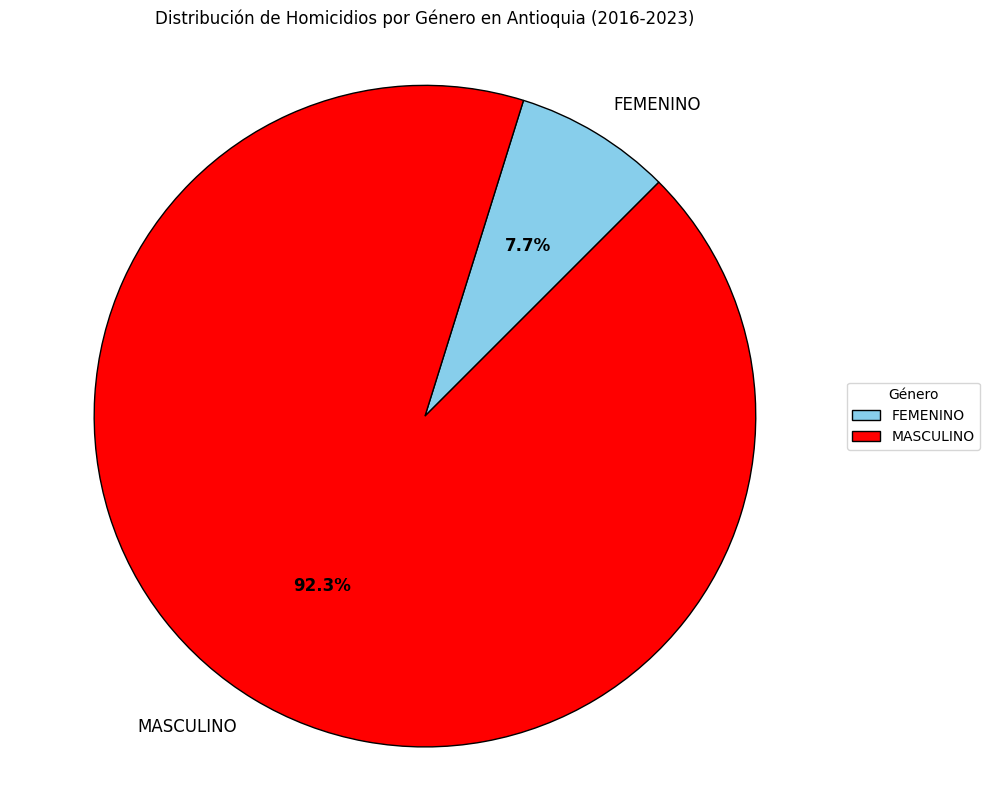

In [25]:
# Agrupamos por GENERO y sumamos la cantidad de homicidios
df_homi_genero = df_Antioquia.groupby('GENERO')['CANTIDAD'].sum().reset_index()

# Creamos el gráfico
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(df_homi_genero['CANTIDAD'], labels=df_homi_genero['GENERO'], 
                                   autopct='%1.1f%%',  # Mostrar los porcentajes
                                   colors=['skyblue', 'red'], 
                                   startangle=45, 
                                   wedgeprops=dict(width=1, edgecolor='black'))

plt.title(f'Distribución de Homicidios por Género en Antioquia (2016-2023)', pad=20)

for text in texts:
    text.set_fontsize(12)
    text.set_color('black')

# Personalizamos los porcentajes
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')
    autotext.set_weight('bold')

plt.legend(wedges, df_homi_genero['GENERO'], title="Género", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Aseguramos que el gráfico sea circular
plt.axis('equal')

plt.tight_layout()
plt.show()

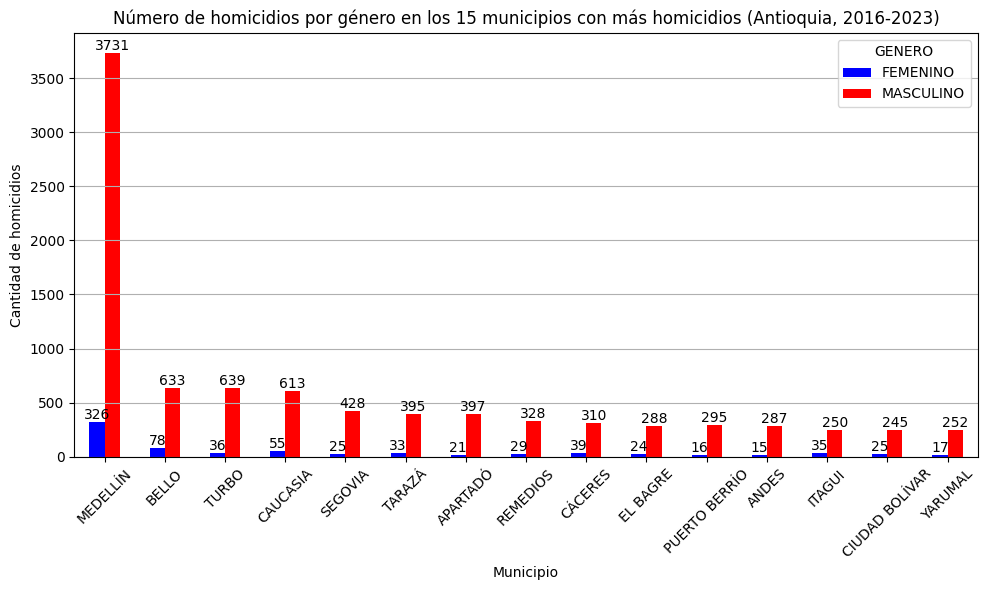

In [26]:
top_n = 15
top_municipios = df_municipios_htotales.sort_values(by='CANTIDAD', ascending=False).head(top_n)['MUNICIPIO']

# Filtramos el DataFrame original para incluir solo los municipios seleccionados
df_top_municipios = df_Antioquia[df_Antioquia['MUNICIPIO'].isin(top_municipios)]

df_genero_municipio = df_top_municipios.groupby(['MUNICIPIO', 'GENERO'])['CANTIDAD'].sum().unstack()

# Calculamos la suma total de homicidios por municipio
df_genero_municipio['TOTAL'] = df_genero_municipio.sum(axis=1)

# Ordenamos el DataFrame por la columna 'TOTAL' en orden descendente
df_genero_municipio = df_genero_municipio.sort_values(by='TOTAL', ascending=False)

# Eliminamos la columna 'TOTAL' ya que solo era necesaria para el ordenamiento
df_genero_municipio = df_genero_municipio.drop(columns='TOTAL')

# Creamos el gráfico de barras agrupadas
ax = df_genero_municipio.plot(kind='bar', figsize=(10, 6), color=['blue', 'red'])

plt.title(f'Número de homicidios por género en los {top_n} municipios con más homicidios (Antioquia, 2016-2023)')
plt.xlabel('Municipio')
plt.ylabel('Cantidad de homicidios')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='%.0f')  # Muestra valores enteros sobre las barras

plt.tight_layout()
plt.grid(axis='y')
plt.show()

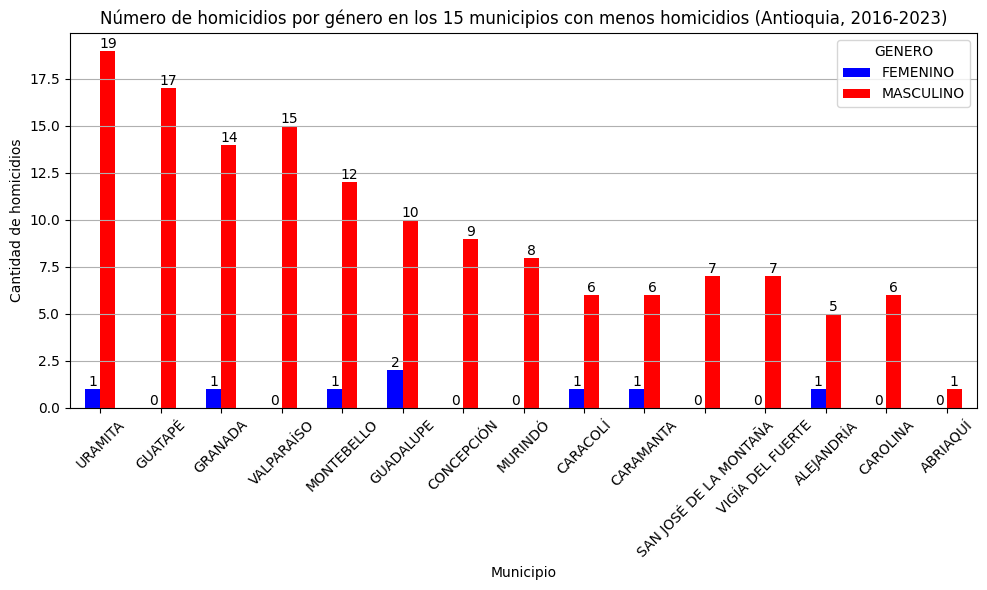

In [27]:
sub_n = 15
sub_municipios = df_municipios_htotales.sort_values(by='CANTIDAD', ascending=False).tail(sub_n)['MUNICIPIO']

# Filtramos el DataFrame original para incluir solo los municipios seleccionados
df_sub_municipios = df_Antioquia[df_Antioquia['MUNICIPIO'].isin(sub_municipios)]

df_genero_municipio = df_sub_municipios.groupby(['MUNICIPIO', 'GENERO'])['CANTIDAD'].sum().unstack()

# Calculamos la suma total de homicidios por municipio
df_genero_municipio['TOTAL'] = df_genero_municipio.sum(axis=1)

# Ordenamos el DataFrame por la columna 'TOTAL' en orden descendente
df_genero_municipio = df_genero_municipio.sort_values(by='TOTAL', ascending=False)

# Eliminamos la columna 'TOTAL' ya que solo era necesaria para el ordenamiento
df_genero_municipio = df_genero_municipio.drop(columns='TOTAL')

# Creamos el gráfico de barras agrupadas
ax = df_genero_municipio.plot(kind='bar', figsize=(10, 6), color=['blue', 'red'])

plt.title(f'Número de homicidios por género en los {sub_n} municipios con menos homicidios (Antioquia, 2016-2023)')
plt.xlabel('Municipio')
plt.ylabel('Cantidad de homicidios')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='%.0f')  # Muestra valores enteros sobre las barras

plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [28]:
print(tabulate(df_genero_municipio.fillna(0), headers='keys', tablefmt='grid', showindex=True))

+------------------------+------------+-------------+
| MUNICIPIO              |   FEMENINO |   MASCULINO |
+========================+============+=============+
| URAMITA                |          1 |          19 |
+------------------------+------------+-------------+
| GUATAPÉ                |          0 |          17 |
+------------------------+------------+-------------+
| GRANADA                |          1 |          14 |
+------------------------+------------+-------------+
| VALPARAÍSO             |          0 |          15 |
+------------------------+------------+-------------+
| MONTEBELLO             |          1 |          12 |
+------------------------+------------+-------------+
| GUADALUPE              |          2 |          10 |
+------------------------+------------+-------------+
| CONCEPCIÓN             |          0 |           9 |
+------------------------+------------+-------------+
| MURINDÓ                |          0 |           8 |
+------------------------+--

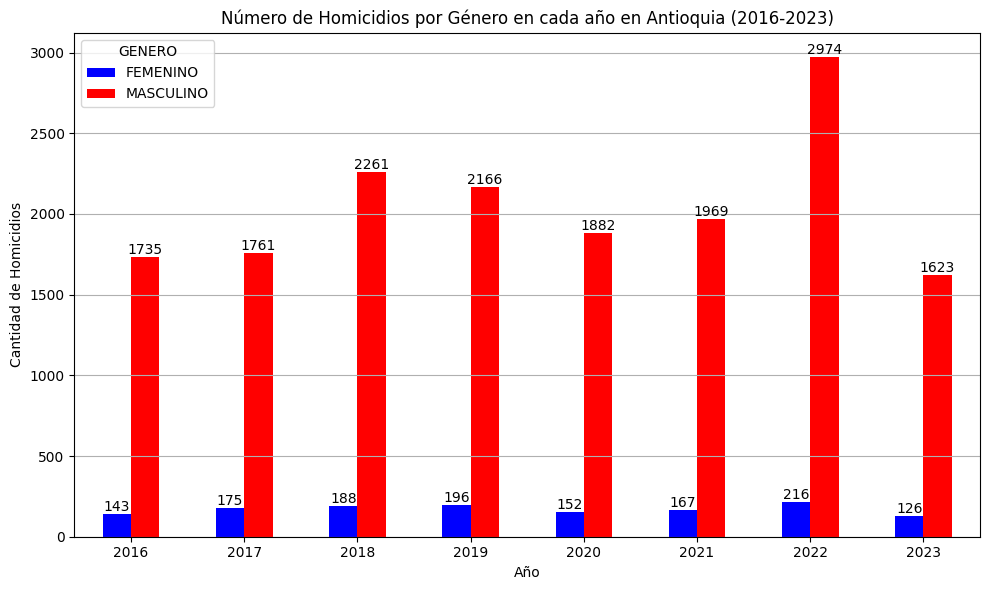

In [29]:
# Agrupamos por AÑO y GÉNERO, y sumamos la cantidad de homicidios
df_genero_anio = df_Antioquia.groupby(['AÑO', 'GENERO'])['CANTIDAD'].sum().unstack()

# Creamos un gráfico de barras agrupadas
ax = df_genero_anio.plot(kind='bar', figsize=(10, 6), color=['blue', 'red'])

plt.title('Número de Homicidios por Género en cada año en Antioquia (2016-2023)')
plt.xlabel('Año')
plt.xticks(rotation=0)
plt.ylabel('Cantidad de Homicidios')

# Añadimos etiquetas sobre las barras
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='%.0f')  # Muestra valores enteros sobre las barras

# Ajustamos el diseño y mostrar la cuadrícula
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [30]:
print(tabulate(df_genero_anio.fillna(0), headers='keys', tablefmt='double_grid', showindex=True))

╔═══════╦════════════╦═════════════╗
║   AÑO ║   FEMENINO ║   MASCULINO ║
╠═══════╬════════════╬═════════════╣
║  2016 ║        143 ║        1735 ║
╠═══════╬════════════╬═════════════╣
║  2017 ║        175 ║        1761 ║
╠═══════╬════════════╬═════════════╣
║  2018 ║        188 ║        2261 ║
╠═══════╬════════════╬═════════════╣
║  2019 ║        196 ║        2166 ║
╠═══════╬════════════╬═════════════╣
║  2020 ║        152 ║        1882 ║
╠═══════╬════════════╬═════════════╣
║  2021 ║        167 ║        1969 ║
╠═══════╬════════════╬═════════════╣
║  2022 ║        216 ║        2974 ║
╠═══════╬════════════╬═════════════╣
║  2023 ║        126 ║        1623 ║
╚═══════╩════════════╩═════════════╝


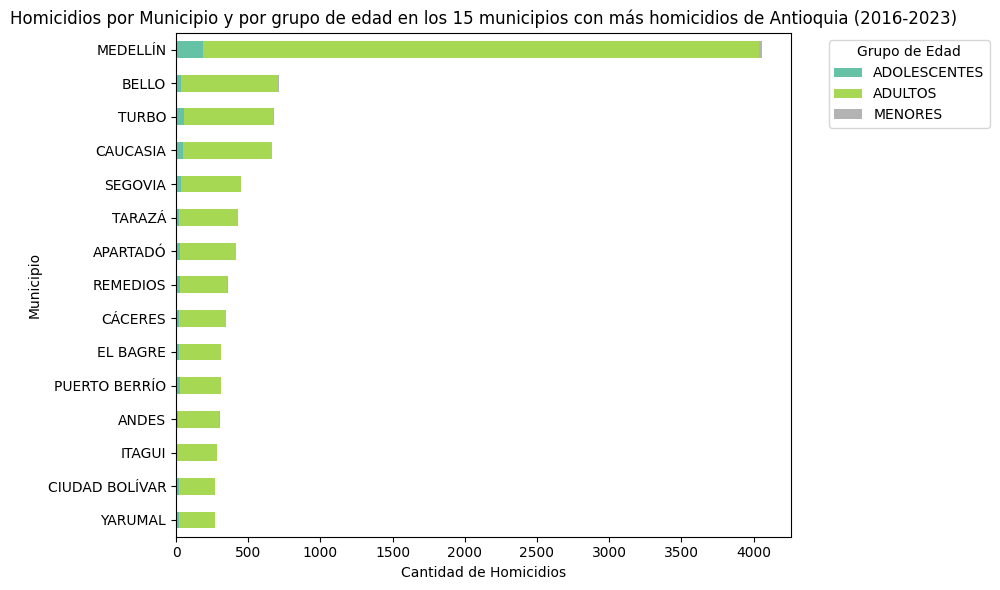

In [31]:
top_n = 15
top_municipios = df_municipios_htotales.sort_values(by='CANTIDAD', ascending=False).head(top_n)['MUNICIPIO']

# Filtramos el DataFrame original para incluir solo los municipios seleccionados
df_top_municipios = df_Antioquia[df_Antioquia['MUNICIPIO'].isin(top_municipios)]

#agrupamos por AÑO y AGRUPA EDAD PERSONA, para hacer un gráfico de barras apiladas de la cantidad de homicidios por año y grupo de persona por edad
df_edad_municipios = df_top_municipios.groupby(['MUNICIPIO', 'AGRUPA EDAD PERSONA'])['CANTIDAD'].sum().unstack()

# Calculamos la suma total de homicidios por municipio
df_edad_municipios['TOTAL'] = df_edad_municipios.sum(axis=1)

# Ordenamos el DataFrame por la columna 'TOTAL' en orden descendente
df_edad_municipios = df_edad_municipios.sort_values(by='TOTAL', ascending=True)

# Eliminamos la columna 'TOTAL' ya que solo era necesaria para el ordenamiento
df_edad_municipios = df_edad_municipios.drop(columns='TOTAL')

# Creamos el gráfico de barras apiladas
ax = df_edad_municipios.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title(f'Homicidios por Municipio y por grupo de edad en los {top_n} municipios con más homicidios de Antioquia (2016-2023)')
plt.xlabel('Cantidad de Homicidios')
plt.ylabel('Municipio')
plt.legend(title='Grupo de Edad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadimos los valores sobre las barras
#for c in ax.containers:
    #ax.bar_label(c, label_type='center', fmt='%.0f')  # Mostrar valores enteros

plt.tight_layout()
plt.grid(False)
plt.show()

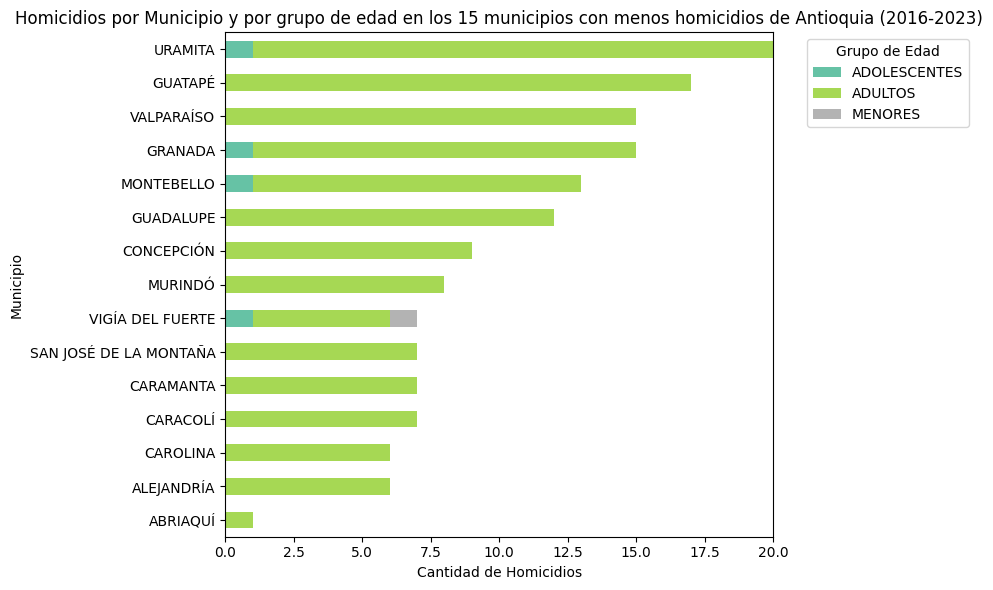

In [32]:
sub_n = 15
sub_municipios = df_municipios_htotales.sort_values(by='CANTIDAD', ascending=False).tail(sub_n)['MUNICIPIO']

# Filtramos el DataFrame original para incluir solo los municipios seleccionados
df_sub_municipios = df_Antioquia[df_Antioquia['MUNICIPIO'].isin(sub_municipios)]

#agrupamos por AÑO y AGRUPA EDAD PERSONA, para hacer un gráfico de barras apiladas de la cantidad de homicidios por año y grupo de persona por edad
df_edad_municipios = df_sub_municipios.groupby(['MUNICIPIO', 'AGRUPA EDAD PERSONA'])['CANTIDAD'].sum().unstack()

# Calculamos la suma total de homicidios por municipio
df_edad_municipios['TOTAL'] = df_edad_municipios.sum(axis=1)

# Ordenamos el DataFrame por la columna 'TOTAL' en orden descendente
df_edad_municipios = df_edad_municipios.sort_values(by='TOTAL', ascending=True)

# Eliminamos la columna 'TOTAL' ya que solo era necesaria para el ordenamiento
df_edad_municipios = df_edad_municipios.drop(columns='TOTAL')

# Creamos el gráfico de barras apiladas
ax = df_edad_municipios.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title(f'Homicidios por Municipio y por grupo de edad en los {top_n} municipios con menos homicidios de Antioquia (2016-2023)')
plt.xlabel('Cantidad de Homicidios')
plt.ylabel('Municipio')
plt.legend(title='Grupo de Edad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadimos los valores sobre las barras
#for c in ax.containers:
    #ax.bar_label(c, label_type='center', fmt='%.0f')  # Mostrar valores enteros

plt.tight_layout()
plt.grid(False)
plt.show()

In [33]:
print(tabulate(df_edad_municipios.fillna(0), headers='keys', tablefmt='grid', showindex=True))

+------------------------+----------------+-----------+-----------+
| MUNICIPIO              |   ADOLESCENTES |   ADULTOS |   MENORES |
+========================+================+===========+===========+
| ABRIAQUÍ               |              0 |         1 |         0 |
+------------------------+----------------+-----------+-----------+
| ALEJANDRÍA             |              0 |         6 |         0 |
+------------------------+----------------+-----------+-----------+
| CAROLINA               |              0 |         6 |         0 |
+------------------------+----------------+-----------+-----------+
| CARACOLÍ               |              0 |         7 |         0 |
+------------------------+----------------+-----------+-----------+
| CARAMANTA              |              0 |         7 |         0 |
+------------------------+----------------+-----------+-----------+
| SAN JOSÉ DE LA MONTAÑA |              0 |         7 |         0 |
+------------------------+----------------+-----

<Figure size 1200x800 with 0 Axes>

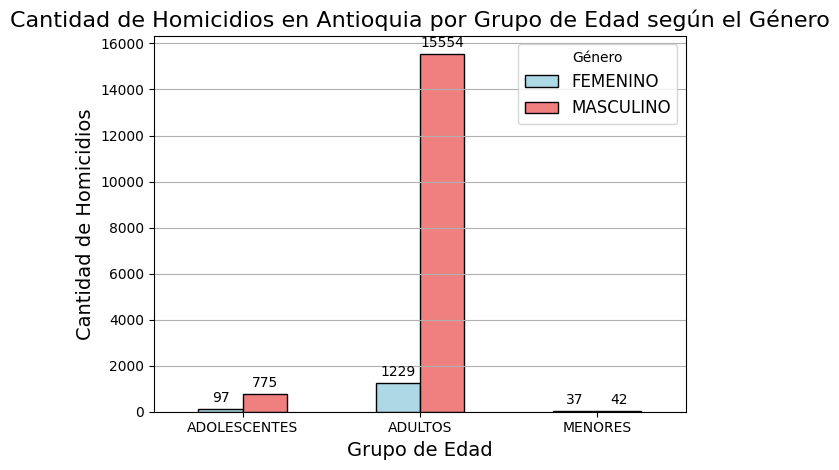

In [34]:
# Agrupamos los datos por 'AGRUPA EDAD PERSONA' y 'GENERO', sumando las cantidades
grupo_edad_genero = df_Antioquia.groupby(['AGRUPA EDAD PERSONA', 'GENERO'])['CANTIDAD'].sum().unstack()

# Creamos el gráfico
plt.figure(figsize=(12, 8))
bars = grupo_edad_genero.plot(kind='bar', stacked=False, color=['lightblue', 'lightcoral'], edgecolor='black')

# Añadir las anotaciones de los valores sobre cada barra
for bar in bars.containers:
    for rectangle in bar:
        height = rectangle.get_height()
        if height > 0:  # Solo mostrar anotaciones para barras con valor positivo
            plt.annotate(f'{int(height)}',  # Convertir a entero para mostrar sin decimales
                         xy=(rectangle.get_x() + rectangle.get_width() / 2, height),  # Coordenadas
                         xytext=(0, 3),  # Desplazamiento del texto
                         textcoords='offset points',
                         ha='center', va='bottom', fontsize=10, color='black')

plt.title('Cantidad de Homicidios en Antioquia por Grupo de Edad según el Género', fontsize=16)
plt.xlabel('Grupo de Edad', fontsize=14)
plt.ylabel('Cantidad de Homicidios', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Género', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

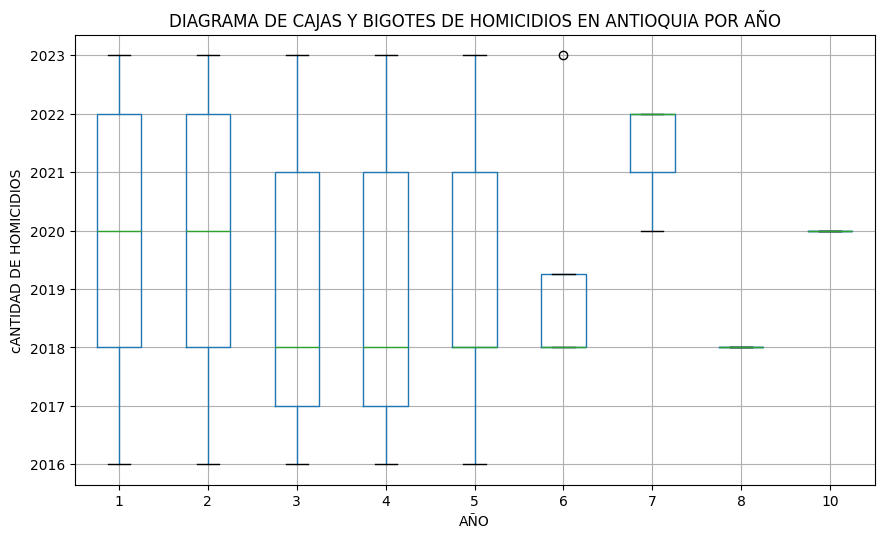

In [35]:
#intento hacer un diagrama de cajas y bigotes. Pero parece que no funciona como esperaba
fig, ax=plt.subplots(figsize=(10,6))
df_Antioquia.boxplot(column='AÑO', by='CANTIDAD', ax=ax)
ax.set_xlabel('AÑO')
ax.set_ylabel('cANTIDAD DE HOMICIDIOS')
ax.set_title('DIAGRAMA DE CAJAS Y BIGOTES DE HOMICIDIOS EN ANTIOQUIA POR AÑO')
plt.suptitle('')
plt.show()

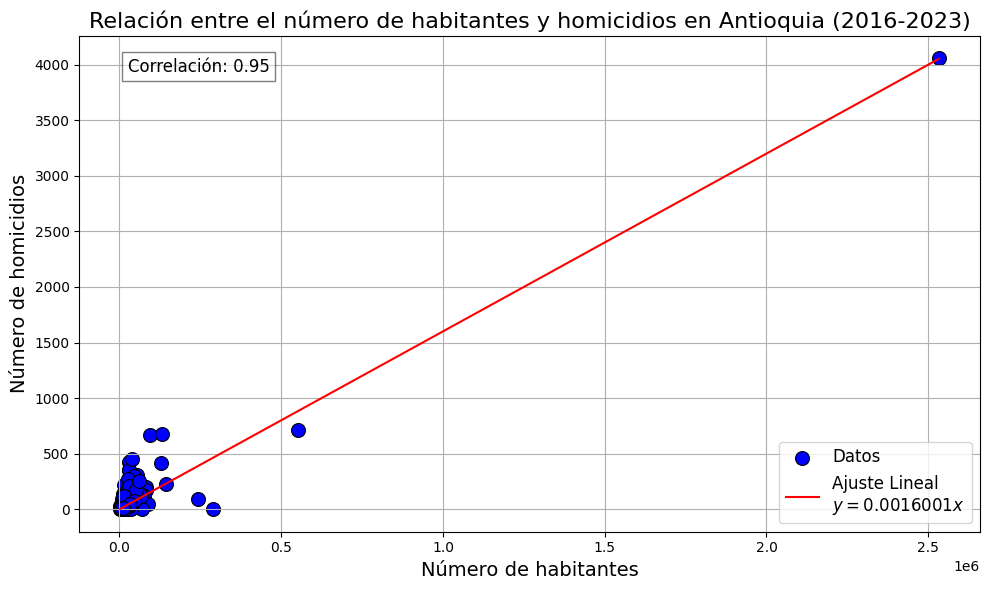

Pendiente (slope): 0.0016001
La correlación entre el número de habitantes y el número de homicidios es: 0.95


In [36]:
df_habitantes=pd.read_excel('demografia-poblacion/poblacion-antioquia.xlsx')
df_habitantes_homicidios = df_habitantes.merge(df_homicidios_municipios, how='left', left_on='Municipios', right_on='MUNICIPIO')

# Limpiamos los datos: eliminamos filas con valores nulos
df_habitantes_homicidios['CANTIDAD'] = df_habitantes_homicidios['CANTIDAD'].fillna(0)

# Extraemos los valores de 'Personas' y 'CANTIDAD'
x = df_habitantes_homicidios['Personas']
y = df_habitantes_homicidios['CANTIDAD']

# Verificamos que los datos no tengan valores negativos o cero que puedan causar problemas en la regresión
x = x[x >= 0]
y = y[y >= 0]

df_habitantes_homicidios = df_habitantes_homicidios[df_habitantes_homicidios['Personas'].isin(x)]
df_habitantes_homicidios = df_habitantes_homicidios[df_habitantes_homicidios['CANTIDAD'].isin(y)]

# Cálculo de la regresión lineal forzada al origen (sin intercepto)
# Usamos np.linalg.lstsq para calcular la pendiente
X = np.vstack([x]).T  # Necesitamos transformar los datos de entrada en una matriz de diseño
slope, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

# Creamos los valores ajustados para la curva
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = slope * x_vals

correlacion = df_habitantes_homicidios['Personas'].corr(df_habitantes_homicidios['CANTIDAD'])

# Creamos el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Personas', y='CANTIDAD', data=df_habitantes_homicidios, s=100, color='blue', edgecolor='black', label='Datos')

# Dibujamos la curva de regresión (forzada a pasar por el origen)
plt.plot(x_vals, y_vals, color='red', label=f'Ajuste Lineal \n$y = {slope[0]:.7f}x$')

plt.title('Relación entre el número de habitantes y homicidios en Antioquia (2016-2023)', fontsize=16)
plt.xlabel('Número de habitantes', fontsize=14)
plt.ylabel('Número de homicidios', fontsize=14)
plt.text(0.01 * max(df_habitantes_homicidios['Personas']), 0.97 * max(df_habitantes_homicidios['CANTIDAD']), 
         f'Correlación: {correlacion:.2f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)


plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Devolvemos los parámetros de la regresión
print(f'Pendiente (slope): {slope[0]:.7f}')

# La correlación no tiene sentido si estamos forzando la regresión al origen, pero se podría usar esta
print(f'La correlación entre el número de habitantes y el número de homicidios es: {correlacion:.2f}')

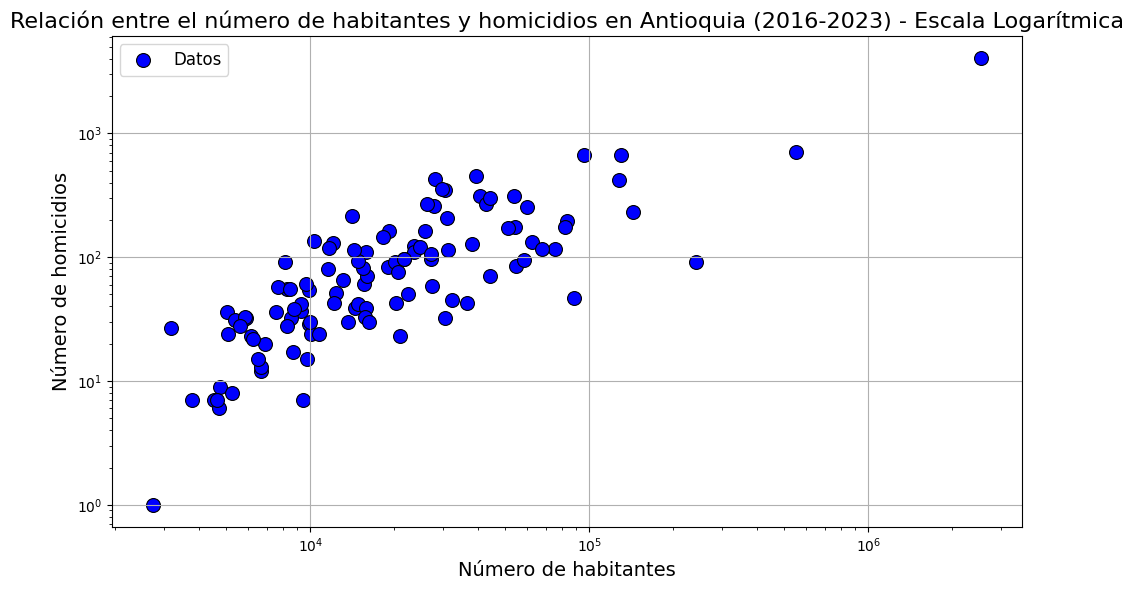

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Personas', y='CANTIDAD', data=df_habitantes_homicidios, s=100, color='blue', edgecolor='black', label='Datos')

plt.title('Relación entre el número de habitantes y homicidios en Antioquia (2016-2023) - Escala Logarítmica', fontsize=16)
plt.xlabel('Número de habitantes', fontsize=14)
plt.ylabel('Número de homicidios', fontsize=14)
plt.grid(True)

# Escalas ajustadas
plt.xscale('log')  #'log' si los datos lo requieren
plt.yscale('log')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

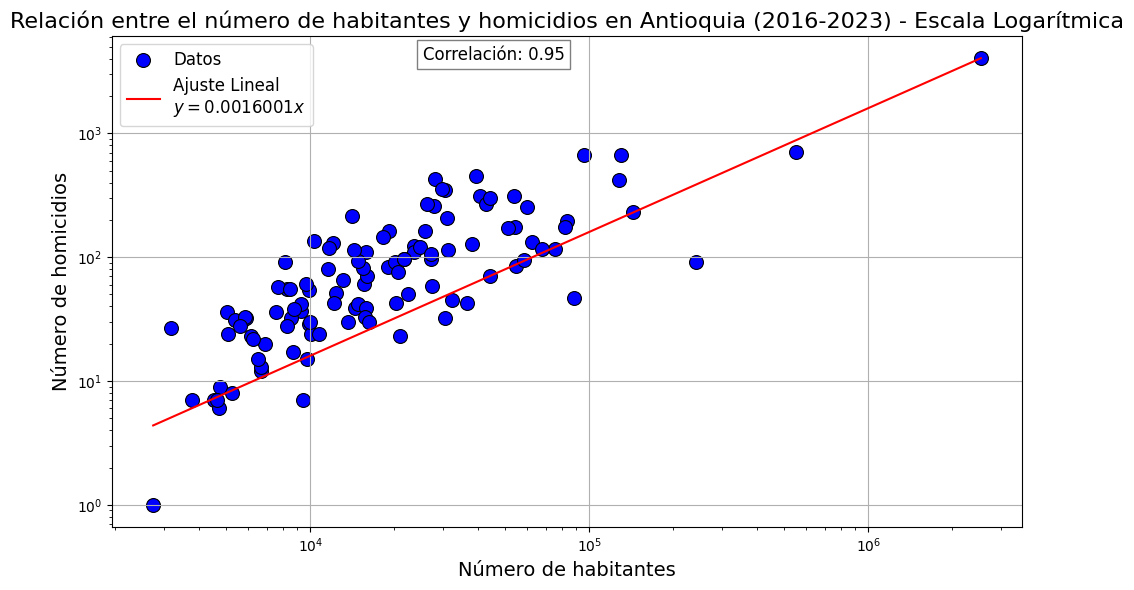

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Personas', y='CANTIDAD', data=df_habitantes_homicidios, s=100, color='blue', edgecolor='black', label='Datos')

# Dibujamos la línea de regresión (forzada a pasar por el origen)
plt.plot(x_vals, y_vals, color='red', label=f'Ajuste Lineal \n$y = {slope[0]:.7f}x$')

plt.title('Relación entre el número de habitantes y homicidios en Antioquia (2016-2023) - Escala Logarítmica', fontsize=16)
plt.xlabel('Número de habitantes', fontsize=14)
plt.ylabel('Número de homicidios', fontsize=14)
plt.text(0.01 * max(df_habitantes_homicidios['Personas']), 0.97 * max(df_habitantes_homicidios['CANTIDAD']), 
         f'Correlación: {correlacion:.2f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)

# Escalas ajustadas
plt.xscale('log')  #'log' si los datos lo requieren
plt.yscale('log')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

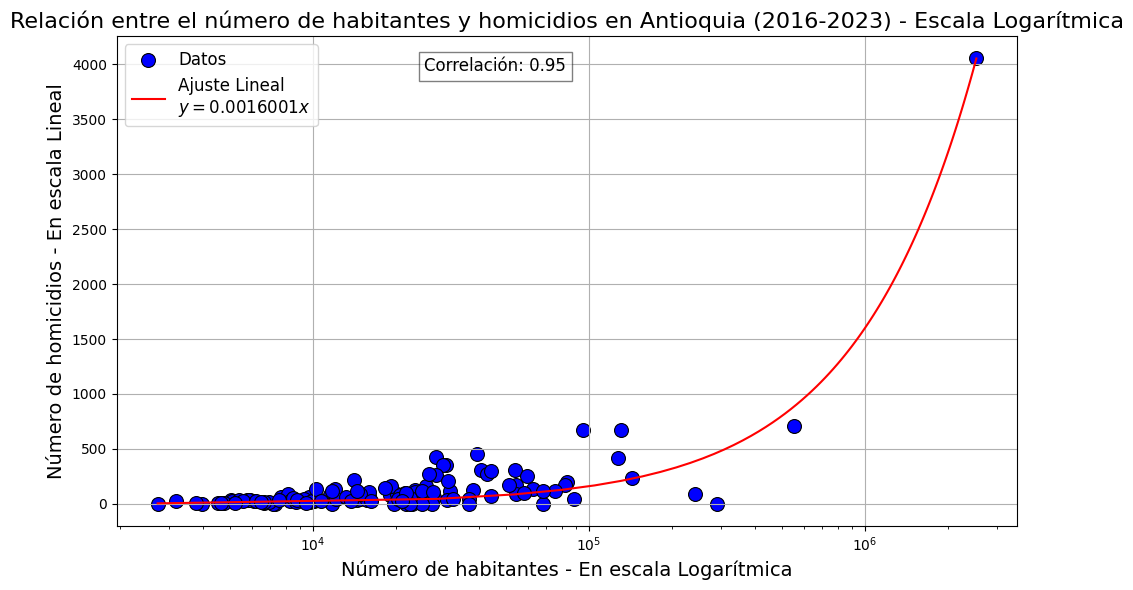

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Personas', y='CANTIDAD', data=df_habitantes_homicidios, s=100, color='blue', edgecolor='black', label='Datos')

# Dibujamos la línea de regresión (forzada a pasar por el origen)
plt.plot(x_vals, y_vals, color='red', label=f'Ajuste Lineal \n$y = {slope[0]:.7f}x$')

plt.title('Relación entre el número de habitantes y homicidios en Antioquia (2016-2023) - Escala Logarítmica', fontsize=16)
plt.xlabel('Número de habitantes - En escala Logarítmica', fontsize=14)
plt.ylabel('Número de homicidios - En escala Lineal', fontsize=14)
plt.text(0.01 * max(df_habitantes_homicidios['Personas']), 0.97 * max(df_habitantes_homicidios['CANTIDAD']), 
         f'Correlación: {correlacion:.2f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)

# Escalas ajustadas
plt.xscale('log')  #'log' si los datos lo requieren
plt.yscale('linear')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

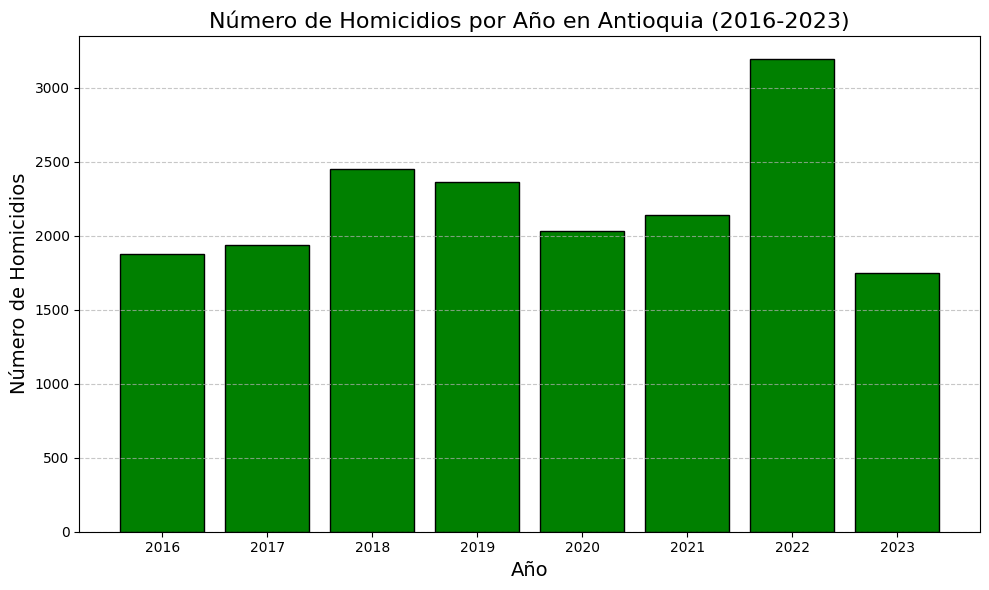

In [40]:
#Analizamos los homicidios por año
df_homi_anio=df_Antioquia.groupby('AÑO')['CANTIDAD'].sum()

plt.figure(figsize=(10, 6))
plt.bar(df_homi_anio.index, df_homi_anio.values, color='green', edgecolor='black')

plt.title('Número de Homicidios por Año en Antioquia (2016-2023)', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Homicidios', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

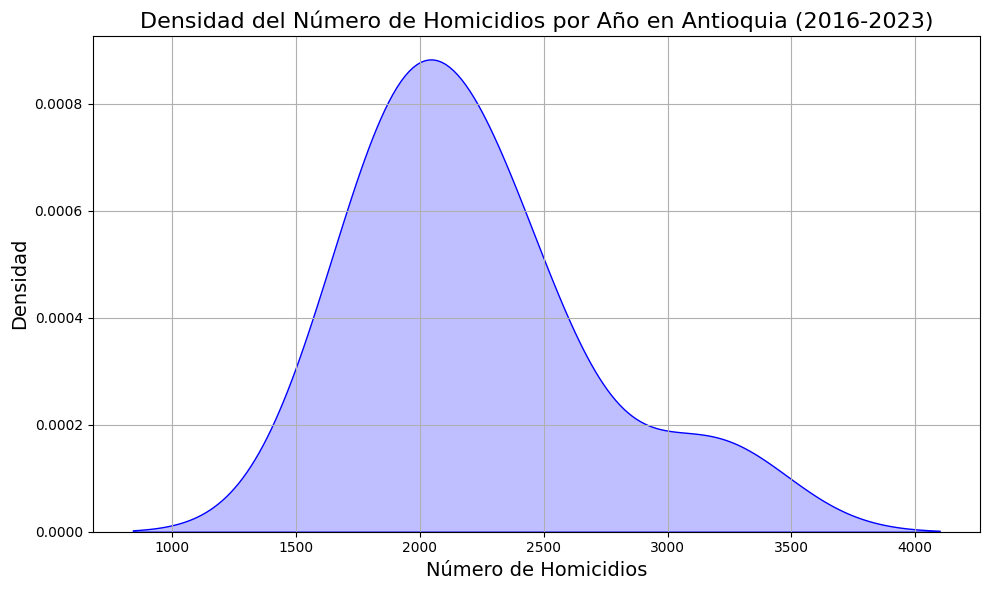

In [41]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_homi_anio.reset_index()['CANTIDAD'], fill=True, color='blue')

# Añadir título y etiquetas
plt.title('Densidad del Número de Homicidios por Año en Antioquia (2016-2023)', fontsize=16)
plt.xlabel('Número de Homicidios', fontsize=14)
plt.ylabel('Densidad', fontsize=14)

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
#comprobación de hipótesis. Nula o alternativa
# Filtramos los datos para incluir solo Medellín
df_medellin = df_Antioquia[df_Antioquia['MUNICIPIO'] == 'MEDELLÍN']

# Creamos tabla de contingencia
tabla_contingencia = pd.crosstab(df_medellin['ARMA MEDIO'], df_medellin['GENERO'])

# Mostramos la tabla de contingencia
print("Tabla de contingencia - Arma empleada - Género \n")
print(tabulate(tabla_contingencia, headers='keys', tablefmt='rounded_grid', showindex=True))

Tabla de contingencia - Arma empleada - Género 

╭────────────────────────────────────┬────────────┬─────────────╮
│ ARMA MEDIO                         │   FEMENINO │   MASCULINO │
├────────────────────────────────────┼────────────┼─────────────┤
│ ALMOHADA                           │          2 │           0 │
├────────────────────────────────────┼────────────┼─────────────┤
│ ARMA BLANCA / CORTOPUNZANTE        │        126 │         893 │
├────────────────────────────────────┼────────────┼─────────────┤
│ ARMA DE FUEGO                      │        110 │        1703 │
├────────────────────────────────────┼────────────┼─────────────┤
│ ARTEFACTO EXPLOSIVO/CARGA DINAMITA │          0 │           1 │
├────────────────────────────────────┼────────────┼─────────────┤
│ BOLSA PLASTICA                     │          2 │          21 │
├────────────────────────────────────┼────────────┼─────────────┤
│ CINTAS/CINTURON                    │          4 │           7 │
├──────────────────────────

In [43]:
# Prueba de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

# Resultados
print(f'Estadístico Chi-cuadrado: {chi2:.2f}')
print(f'Valor p: {p}')
print(f'Grados de libertad: {dof}')
print('Tabla esperada:')
print(expected)

Estadístico Chi-cuadrado: 108.88
Valor p: 3.093102674405681e-17
Grados de libertad: 13
Tabla esperada:
[[1.94309927e-01 1.80569007e+00]
 [9.90009080e+01 9.19999092e+02]
 [1.76141949e+02 1.63685805e+03]
 [9.71549637e-02 9.02845036e-01]
 [2.23456416e+00 2.07654358e+01]
 [1.06870460e+00 9.93129540e+00]
 [3.91534504e+01 3.63846550e+02]
 [2.04025424e+00 1.89597458e+01]
 [9.71549637e-02 9.02845036e-01]
 [9.71549637e-02 9.02845036e-01]
 [9.71549637e-02 9.02845036e-01]
 [5.82929782e-01 5.41707022e+00]
 [9.71549637e-02 9.02845036e-01]
 [9.71549637e-02 9.02845036e-01]]


In [44]:
#ejemplo de uso de el algoritmo KNN para rellenar valores faltantes

# Ejemplo simplificado del DataFrame con valores faltantes en la columna 'CANTIDAD'
data = {
    'MUNICIPIO': ['Medellín', 'Envigado', 'Medellín', 'Envigado', 'Medellín', 'Envigado'],
    'AÑO': [2023, 2023, 2023, 2023, 2023, 2023],
    'MES': [7, 7, 8, 8, 9, 9],
    'CANTIDAD': [15, 5, 10, 2, np.nan, np.nan],
    'POBLACION': [2500000, 230000, 2500000, 230000, 2500000, 230000]
}

# Creamos el DataFrame
df_data = pd.DataFrame(data)

# Inicializamos el imputador KNN
imputer = KNNImputer(n_neighbors=2)

# Imputamos los valores faltantes de 'CANTIDAD' basado en las otras columnas
df_imputed = pd.DataFrame(imputer.fit_transform(df_data[['AÑO', 'MES', 'CANTIDAD', 'POBLACION']]), columns=['AÑO', 'MES', 'CANTIDAD', 'POBLACION'])

# Agregamos de vuelta las columnas categóricas
df_imputed['MUNICIPIO'] = df_data['MUNICIPIO']

# Imprimimos el DataFrame con los valores imputados
print(df_imputed)

      AÑO  MES  CANTIDAD  POBLACION MUNICIPIO
0  2023.0  7.0      15.0  2500000.0  Medellín
1  2023.0  7.0       5.0   230000.0  Envigado
2  2023.0  8.0      10.0  2500000.0  Medellín
3  2023.0  8.0       2.0   230000.0  Envigado
4  2023.0  9.0      12.5  2500000.0  Medellín
5  2023.0  9.0       3.5   230000.0  Envigado
